# Initial Umap

In [ ]:
import os
import pandas as pd
from dotenv import load_dotenv

load_dotenv(dotenv_path="/Users/sarah/Code/bioinformatics-tool/analysis/.env")


df = pd.read_csv(os.getenv("MEDIAN_CENTERED"),index_col=0)

zscored_df = pd.read_csv(os.getenv("ZSCORED"),index_col=0)

clinical_df = pd.read_csv(os.getenv("CLINICAL"),index_col=0)

# Set title as index
#clinical_df_indexed = clinical_df.set_index("title")
clinical_df_indexed = clinical_df.copy()

# Align both
common_samples = df.index.intersection(clinical_df_indexed.index)
expression_df = df.loc[common_samples]
clinical_df_indexed = clinical_df_indexed.loc[common_samples]


In [4]:
# Shows columns with any NaNs and how many there are
na_cols = df.isna().sum()
na_cols = na_cols[na_cols > 0]
print(na_cols)


Series([], dtype: int64)


## UMAP with Z-Scored

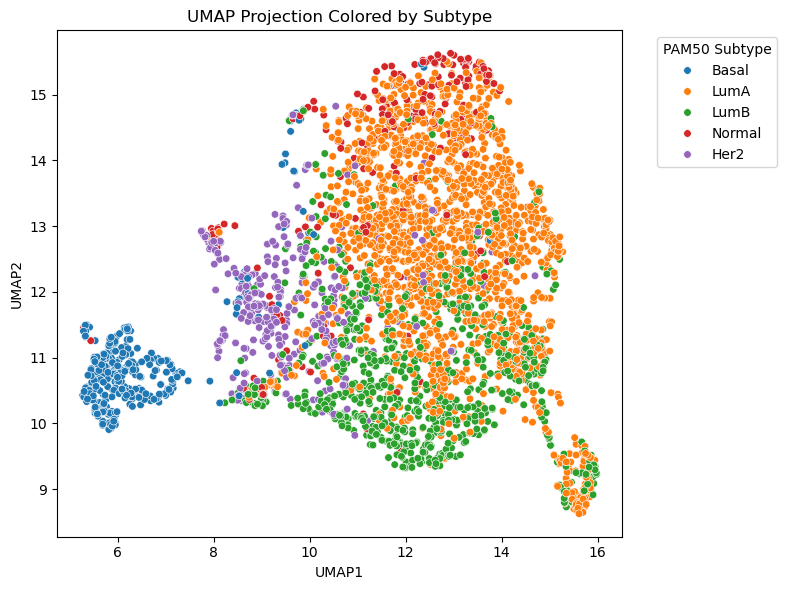

Adjusted Rand Index (UMAP + KMeans): 0.266
Silhouette Score: 0.410


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import umap
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score

clinical_df_indexed = clinical_df_indexed.rename(columns={"characteristics_ch1.20.pam50 subtype": "pam50_subtype"})

# --- PCA preprocessing before UMAP ---
pca = PCA(n_components= 100)
X_pca = pca.fit_transform(zscored_df)

# --- UMAP projection ---
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_pca)

# --- Create DataFrame for plotting ---

umap_df = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"], index=expression_df.index)
umap_df = umap_df.join(clinical_df_indexed)  # This has "pam50_subtype" indexed correctly


# --- Plot UMAP by subtype ---
plt.figure(figsize=(8, 6))
sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue="pam50_subtype", palette="tab10", s=30)
plt.title("UMAP Projection Colored by Subtype")
plt.legend(title="PAM50 Subtype", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# --- Optional: K-Means clustering on UMAP ---
kmeans = KMeans(n_clusters=5, random_state=42)
umap_df["Cluster"] = kmeans.fit_predict(X_umap)

# Drop rows where either subtype or cluster is NaN
umap_df_clean = umap_df.dropna(subset=["pam50_subtype", "Cluster"])

ari = adjusted_rand_score(umap_df["pam50_subtype"], umap_df["Cluster"])
sil = silhouette_score(X_umap, umap_df["Cluster"])
print(f"Adjusted Rand Index (UMAP + KMeans): {ari:.3f}")
print(f"Silhouette Score: {sil:.3f}")



## UMAP with Median-Centered

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import umap
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score

clinical_df_indexed = clinical_df_indexed.rename(columns={"characteristics_ch1.20.pam50 subtype": "pam50_subtype"})

# --- PCA preprocessing before UMAP ---
pca = PCA(n_components= 100)
X_pca = pca.fit_transform(zscored_df)

# --- UMAP projection ---
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_pca)

# --- Create DataFrame for plotting ---

umap_df = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"], index=expression_df.index)
umap_df = umap_df.join(clinical_df_indexed)  # This has "pam50_subtype" indexed correctly


# --- Plot UMAP by subtype ---
plt.figure(figsize=(8, 6))
sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue="pam50_subtype", palette="tab10", s=30)
plt.title("UMAP Projection Colored by Subtype")
plt.legend(title="PAM50 Subtype", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# --- Optional: K-Means clustering on UMAP ---
kmeans = KMeans(n_clusters=5, random_state=42)
umap_df["Cluster"] = kmeans.fit_predict(X_umap)

# Drop rows where either subtype or cluster is NaN
umap_df_clean = umap_df.dropna(subset=["pam50_subtype", "Cluster"])

ari = adjusted_rand_score(umap_df["pam50_subtype"], umap_df["Cluster"])
sil = silhouette_score(X_umap, umap_df["Cluster"])
print(f"Adjusted Rand Index (UMAP + KMeans): {ari:.3f}")
print(f"Silhouette Score: {sil:.3f}")



In [14]:
import numpy as np

results = []

# Range of PCA components to test
for n_components in [10, 25, 50, 75, 100, 150, 200]:
    print(f"Running for PCA n_components = {n_components}")
    
    # PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(expression_df)

    # UMAP
    reducer = umap.UMAP(random_state=42)
    X_umap = reducer.fit_transform(X_pca)

    # KMeans clustering
    kmeans = KMeans(n_clusters=5, random_state=42)
    cluster_labels = kmeans.fit_predict(X_umap)

    # Drop NAs
    mask = ~clinical_df_indexed["pam50_subtype"].isna()
    ari = adjusted_rand_score(clinical_df_indexed["pam50_subtype"][mask], cluster_labels[mask])
    sil = silhouette_score(X_umap, cluster_labels)
    
    results.append((n_components, ari, sil))
    print(f" -> ARI: {ari:.3f} | Silhouette: {sil:.3f}")


Running for PCA n_components = 10
 -> ARI: 0.154 | Silhouette: 0.412
Running for PCA n_components = 25
 -> ARI: 0.159 | Silhouette: 0.377
Running for PCA n_components = 50
 -> ARI: 0.237 | Silhouette: 0.414
Running for PCA n_components = 75
 -> ARI: 0.240 | Silhouette: 0.398
Running for PCA n_components = 100
 -> ARI: 0.179 | Silhouette: 0.393
Running for PCA n_components = 150
 -> ARI: 0.262 | Silhouette: 0.387
Running for PCA n_components = 200
 -> ARI: 0.248 | Silhouette: 0.399


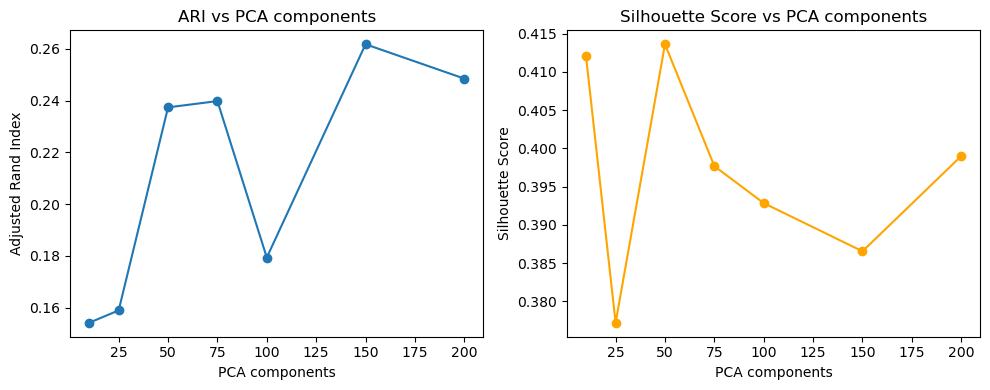

In [15]:
import matplotlib.pyplot as plt

pca_vals, ari_vals, sil_vals = zip(*results)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(pca_vals, ari_vals, marker='o')
plt.title("ARI vs PCA components")
plt.xlabel("PCA components")
plt.ylabel("Adjusted Rand Index")

plt.subplot(1, 2, 2)
plt.plot(pca_vals, sil_vals, marker='o', color='orange')
plt.title("Silhouette Score vs PCA components")
plt.xlabel("PCA components")
plt.ylabel("Silhouette Score")

plt.tight_layout()
plt.show()


# Filtered

In [7]:
import pandas as pd

df = pd.read_csv("/Users/sarah/Code/bioinformatics-tool/data/GSE96058_median_centered.csv",index_col=0)

clinical_df = pd.read_csv("/Users/sarah/Code/bioinformatics-tool/data/GSE96058_clinical_metadata_cleaned.csv", index_col=0)

# Set title as index
clinical_df_indexed = clinical_df.set_index("title")

# Align both
common_samples = df.index.intersection(clinical_df_indexed.index)
expression_df = df.loc[common_samples]
clinical_df_indexed = clinical_df_indexed.loc[common_samples]


Adjusted Rand Index (UMAP + KMeans): 0.236
Silhouette Score: 0.422


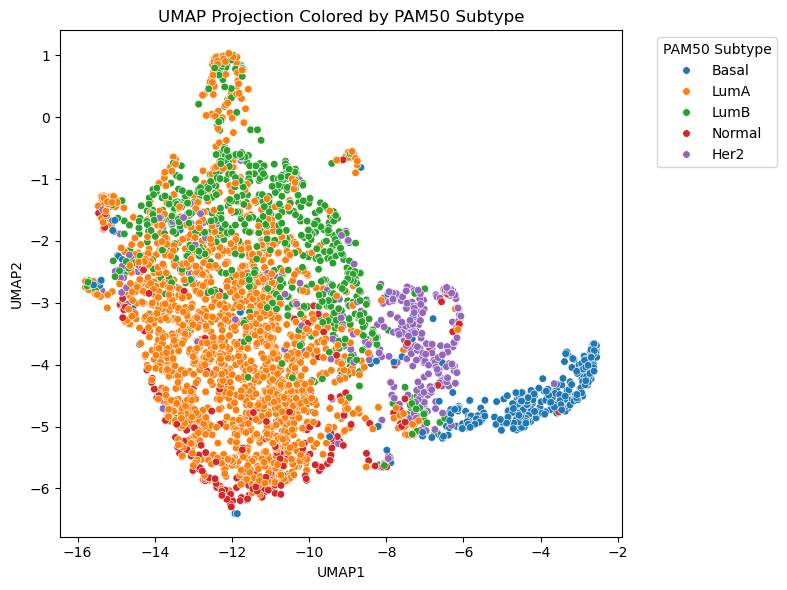

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
import umap


# --- Clean and filter expression data ---
# Ensure numeric types and remove non-numeric columns
expression_df = expression_df.apply(pd.to_numeric, errors='coerce')
expression_df = expression_df.dropna(axis=1, how='any')  # drop genes with NaNs

## --- Variance filtering ---
selector = VarianceThreshold(threshold=0.5)
expression_filtered_np = selector.fit_transform(expression_df)  # shape: (samples x selected genes)

# Get gene names that passed the filter
filtered_genes = expression_df.columns[selector.get_support()]

# Reconstruct filtered DataFrame
expression_filtered = pd.DataFrame(expression_filtered_np, index=expression_df.index, columns=filtered_genes)

# --- PCA + UMAP ---
pca = PCA(n_components=50)
X_pca = pca.fit_transform(expression_filtered)

reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_pca)


# --- Combine with clinical metadata ---
umap_df = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"], index=expression_filtered.index)
umap_df = umap_df.join(clinical_df_indexed)

# Fix subtype column name if needed
umap_df = umap_df.rename(columns={"characteristics_ch1.20.pam50 subtype": "pam50_subtype"})

# Drop rows without subtype
umap_df = umap_df.dropna(subset=["pam50_subtype"])


# --- Clustering ---
kmeans = KMeans(n_clusters=5, random_state=42)
umap_df["Cluster"] = kmeans.fit_predict(X_umap)


# --- Evaluation ---
ari = adjusted_rand_score(umap_df["pam50_subtype"], umap_df["Cluster"])
sil = silhouette_score(X_umap, umap_df["Cluster"])
print(f"Adjusted Rand Index (UMAP + KMeans): {ari:.3f}")
print(f"Silhouette Score: {sil:.3f}")


# --- UMAP plot colored by PAM50 subtype ---
plt.figure(figsize=(8, 6))
sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue="pam50_subtype", palette="tab10", s=30)
plt.title("UMAP Projection Colored by PAM50 Subtype")
plt.legend(title="PAM50 Subtype", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# HBDSCAN / KMeans


==> PCA n_components = 10
KMeans ARI: 0.147 | Silhouette: 0.409
HDBSCAN ARI: 0.134 | Silhouette: 0.332

==> PCA n_components = 25


/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


KMeans ARI: 0.123 | Silhouette: 0.401
HDBSCAN ARI: -0.003 | Silhouette: 0.157

==> PCA n_components = 50


/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


KMeans ARI: 0.138 | Silhouette: 0.382
HDBSCAN ARI: -0.002 | Silhouette: 0.183

==> PCA n_components = 75


/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


KMeans ARI: 0.236 | Silhouette: 0.424
HDBSCAN ARI: 0.149 | Silhouette: 0.448

==> PCA n_components = 100


/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


KMeans ARI: 0.203 | Silhouette: 0.385
HDBSCAN ARI: 0.117 | Silhouette: 0.514

==> PCA n_components = 150


/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


KMeans ARI: 0.231 | Silhouette: 0.414
HDBSCAN ARI: 0.015 | Silhouette: 0.197

==> PCA n_components = 200


/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


KMeans ARI: 0.246 | Silhouette: 0.396
HDBSCAN ARI: 0.185 | Silhouette: -0.066


/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


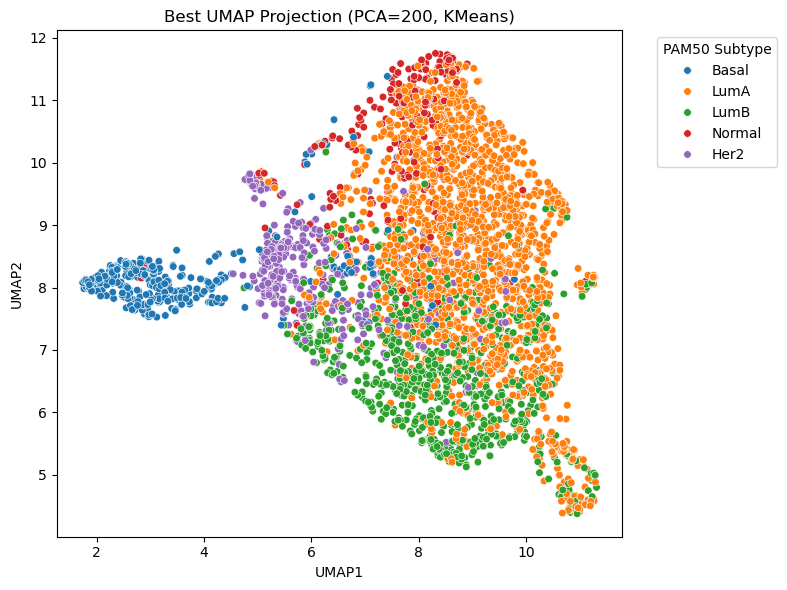

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
import umap
import hdbscan

# Rename PAM50 column
clinical_df_indexed = clinical_df_indexed.rename(columns={"characteristics_ch1.20.pam50 subtype": "pam50_subtype"})


variances = expression_df.var(axis=0)
top_genes = variances.sort_values(ascending=False).head(5000).index
filtered_df = expression_df[top_genes]


# Store results
results = []
best_result = None

# Test multiple PCA n_components
for n_components in [10, 25, 50, 75, 100, 150, 200]:
    print(f"\n==> PCA n_components = {n_components}")
    
    # --- PCA ---
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(filtered_df)

    # --- UMAP ---
    reducer = umap.UMAP(random_state=42)
    X_umap = reducer.fit_transform(X_pca)

    # --- KMeans ---
    kmeans = KMeans(n_clusters=5, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_umap)

    valid_samples = ~clinical_df_indexed["pam50_subtype"].isna()
    pam50_labels = clinical_df_indexed.loc[valid_samples, "pam50_subtype"]

    kmeans_labels_valid = pd.Series(kmeans_labels, index=filtered_df.index)[valid_samples]
    ari_km = adjusted_rand_score(pam50_labels, kmeans_labels_valid)
    sil_km = silhouette_score(X_umap, kmeans_labels)
    results.append({"method": "KMeans", "n_components": n_components, "ARI": ari_km, "Silhouette": sil_km})
    print(f"KMeans ARI: {ari_km:.3f} | Silhouette: {sil_km:.3f}")

    # Track best result
    if best_result is None or ari_km > best_result["ARI"]:
        best_result = {
            "n_components": n_components,
            "method": "KMeans",
            "X_umap": X_umap,
            "labels": kmeans_labels,
            "ARI": ari_km 
        }

    # --- HDBSCAN ---
    clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
    hdb_labels = clusterer.fit_predict(X_umap)

    mask = (hdb_labels != -1)
    if mask.sum() > 0:
        hdb_valid_labels = pd.Series(hdb_labels, index=filtered_df.index)[valid_samples & mask]
        ari_hdb = adjusted_rand_score(pam50_labels[mask], hdb_valid_labels)
        sil_hdb = silhouette_score(X_umap[mask], hdb_labels[mask])
        results.append({"method": "HDBSCAN", "n_components": n_components, "ARI": ari_hdb, "Silhouette": sil_hdb})
        print(f"HDBSCAN ARI: {ari_hdb:.3f} | Silhouette: {sil_hdb:.3f}")

# === Plot UMAP of best KMeans result ===
X_umap_best = best_result["X_umap"]
labels_best = best_result["labels"]

umap_df = pd.DataFrame(X_umap_best, columns=["UMAP1", "UMAP2"], index=filtered_df.index)
umap_df["Cluster"] = labels_best
umap_df = umap_df.join(clinical_df_indexed)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue="pam50_subtype", palette="tab10", s=30)
plt.title(f"Best UMAP Projection (PCA={best_result['n_components']}, KMeans)")
plt.legend(title="PAM50 Subtype", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [26]:
results_df = pd.DataFrame(results)


In [27]:
best_overall = results_df.sort_values(by="ARI", ascending=False).iloc[0]
print("Best overall result:")
print(best_overall)


Best overall result:
method            KMeans
n_components         200
ARI              0.24628
Silhouette      0.395754
Name: 12, dtype: object


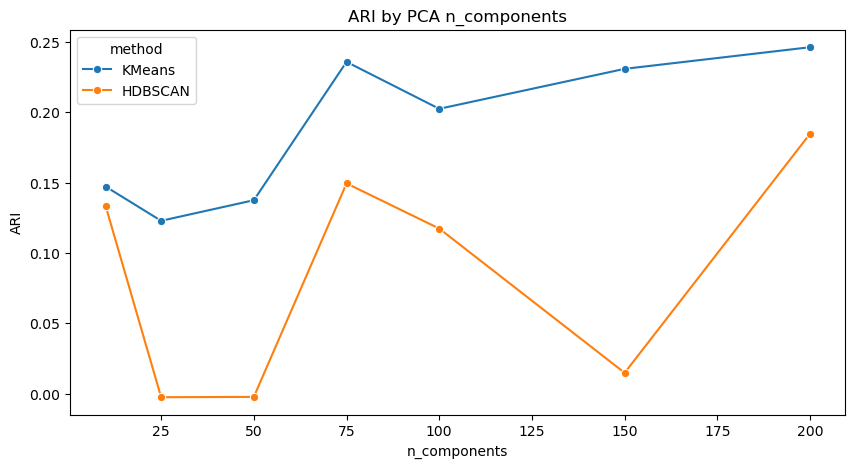

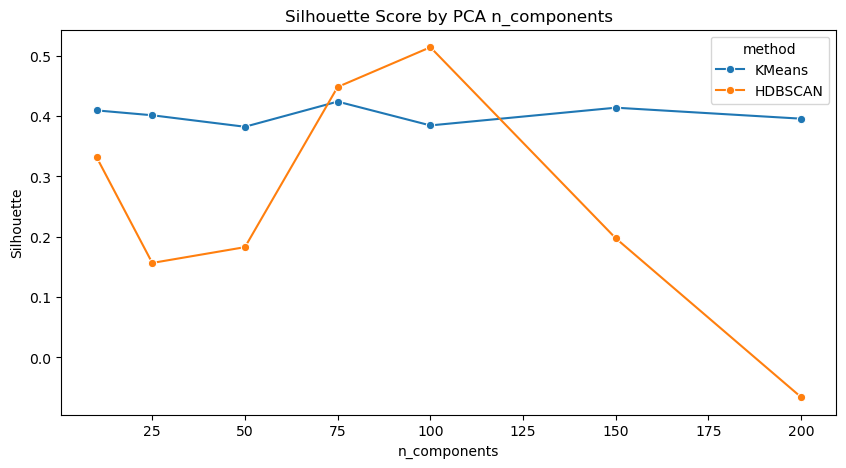

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.lineplot(data=results_df, x="n_components", y="ARI", hue="method", marker="o")
plt.title("ARI by PCA n_components")
plt.show()

plt.figure(figsize=(10, 5))
sns.lineplot(data=results_df, x="n_components", y="Silhouette", hue="method", marker="o")
plt.title("Silhouette Score by PCA n_components")
plt.show()
